**Universidade Tecnológica Federal do Paraná**

**Programa de Pós-Graduação em Informática (PPGI)**

**Disciplina:** Linguagens de Programação

**Professores:** Dr. Adriano Rivolli (UTFPR-CP) e Dr. Marlon Marcon (UTFPR-DV)

**Aluno:** Wellington Guimarães de Almeida

# Projeto Avaliativo

## Descrição do projeto

##Pré-requisitos

Para a realização deste projeto faz-se necessário a instalação e importação das seguintes bibliotecas:

- [Pandas](https://pandas.pydata.org/) - Biblioteca de análise e manipulação de dados
- [Matplotlib](https://matplotlib.org/) - Biblioteca para criação de visualizações de dados
- [NumPy](https://numpy.org/) - Biblioteca para realização de cálculos numéricos
- [ipywidgets](https://github.com/jupyter-widgets/ipywidgets) - Biblioteca de componentes visuais interativos
- [Geopandas](https://geopandas.org/) - Biblioteca para manipulação de dados geoespaciais
- [geobr](https://github.com/ipeaGIT/geobr) - Biblioteca de dados geoespaciais brasileiros

<!--
- [Descartes](https://pypi.org/project/descartes/) - Biblioteca para plotagem de objetos geométricos no matplotlib -->

### Instalação das bibliotecas necessárias


In [ ]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install ipywidgets
!pip install geopandas
!pip install geobr
!pip install descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 85.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.5 MB/s eta 0:00:00
     ━━━━

###Importação das bibliotecas necessárias

In [ ]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import geopandas as gpd
import geobr

##Definição de parâmetros da análise

A análise realizada neste projeto tem seu escopo restrito à unidade da federação selecionada a seguir.

In [ ]:
uf_list = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# Definição de parâmetros
titulo = widgets.Label('Selecione o escopo da análise:')

uf_select = widgets.Dropdown(
options=uf_list,
value='PR',
description='Estado: ')

widgets.VBox([titulo, uf_select])

##Desenvolvimento

###Carga dos dados

In [ ]:
# Função para recuperação dos dados brutos das antenas
def carrega_dados_uf_selecionada(uf):  
  url_antenas = 'https://github.com/WellingtonAlmeida/erbs/raw/main/dados-anatel/'+uf+'.csv'
  df_antenas = pd.read_csv(url_antenas, sep=';')
  return df_antenas

# Função para recuperação dos dados de municípios
def carrega_dados_municipios():
  url_municipios = 'https://github.com/WellingtonAlmeida/erbs/raw/main/populacao-municipios.csv'
  df_municipios = pd.read_csv(url_municipios, sep=';')
  return df_municipios

uf = uf_select.value.lower()
df_antenas = carrega_dados_uf_selecionada(uf)
df_municipios = carrega_dados_municipios()

<ipython-input-4-d91a84f5f778>:4: DtypeWarning: Columns (13,18,19,20,22,23,24,28,29,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_antenas = pd.read_csv(url_antenas, sep=';')


### Tratamento dos dados

In [ ]:
# Tratamento dos dados de antenas
def trata_dados_antenas(df_antenas):
  # Seleção das colunas utilizadas na análise
  colunas = ['NomeEntidade', 'NumEstacao', 'SiglaUf', 'CodMunicipio', 'Tecnologia',  'AlturaAntena',  'PotenciaTransmissorWatts', 'DataLicenciamento', 'DataPrimeiroLicenciamento', 'Latitude', 'Longitude']
  novos_nomes_colunas = ['operadora', 'estacao', 'uf', 'codigo_municipio', 'tecnologia', 'altura_antena', 'potencia_transmissor', 'data_licenciamento', 'data_primeiro_licenciamento', 'latitude', 'longitude']
  df_antenas_uf = df_antenas[colunas]
  df_antenas_uf.columns = novos_nomes_colunas

  # Descarte dos registros com dados incompletos
  df_antenas_uf = df_antenas_uf.dropna()

  # Descarta coordenadas fora do limite nacional  
  limite_sul = -34
  limite_norte = 6
  limite_leste = -35
  limite_oeste = -73
  selecao = df_antenas_uf[ df_antenas_uf['latitude'] > limite_norte ].index
  df_antenas_uf.drop(selecao , inplace=True)
  selecao = df_antenas_uf[ df_antenas_uf['latitude'] < limite_sul ].index
  df_antenas_uf.drop(selecao , inplace=True)
  selecao = df_antenas_uf[ df_antenas_uf['longitude'] > limite_leste ].index
  df_antenas_uf.drop(selecao , inplace=True)
  selecao = df_antenas_uf[ df_antenas_uf['longitude'] < limite_oeste ].index
  df_antenas_uf.drop(selecao , inplace=True)

  # Ajuste nos tipos de dados
  df_antenas_uf['codigo_municipio'] = df_antenas_uf['codigo_municipio'].astype(int)
  df_antenas_uf['data_licenciamento'] = pd.to_datetime(df_antenas_uf['data_licenciamento'], format='%Y-%m-%d')
  df_antenas_uf['data_primeiro_licenciamento'] = pd.to_datetime(df_antenas_uf['data_primeiro_licenciamento'], format='%Y-%m-%d')
  return df_antenas_uf

# Tratamento dos dados de municípios
def trata_dados_municipios(df_municipios, uf):
  df_municipios_uf = df_municipios[df_municipios['UF']==uf.upper()]
  # Ajusta colunas da tabela de município
  novos_nomes_colunas = ['uf', 'codigo_uf', 'codigo_municipio', 'municipio', 'populacao']
  df_municipios_uf.columns = novos_nomes_colunas
  df_municipios_uf['codigo_municipio']=(df_municipios_uf['codigo_uf']*100000)+df_municipios_uf['codigo_municipio']
  df_municipios_uf.drop(columns=['codigo_uf'], inplace=True)  
  return df_municipios_uf

# Cria dataframe de ERB's
def cria_dataframe_erbs(df_antenas_uf, df_municipios_uf):
  return df_antenas_uf.merge(df_municipios_uf)

df_antenas_uf = trata_dados_antenas(df_antenas)
df_municipios_uf = trata_dados_municipios(df_municipios, uf)
df_erbs_uf = cria_dataframe_erbs(df_antenas_uf, df_municipios_uf)


<ipython-input-5-39cd210ac389>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_municipios_uf['codigo_municipio']=(df_municipios_uf['codigo_uf']*100000)+df_municipios_uf['codigo_municipio']
<ipython-input-5-39cd210ac389>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_municipios_uf.drop(columns=['codigo_uf'], inplace=True)


### Análise e Visualização dos dados

#### Número de antenas por operadora no Estado

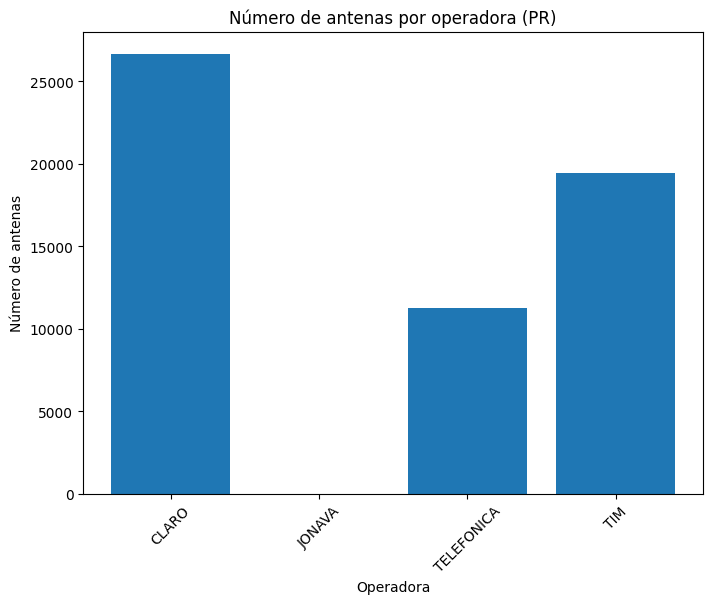

In [ ]:
def gera_grafico_antenas_por_operadora():
  df = df_erbs_uf.groupby(['operadora']).agg({'estacao': 'count'}).reset_index()
  operadora = [ o.split()[0] for o in df['operadora'].to_list() ]
  numero_antenas = df['estacao'].to_list()

  plt.figure(figsize=(8, 6))

  plt.bar(operadora, numero_antenas)
  plt.title('Número de antenas por operadora ('+uf.upper()+')')
  plt.xlabel('Operadora')
  plt.ylabel('Número de antenas')

  plt.xticks(rotation = 45) 
  plt.show()

gera_grafico_antenas_por_operadora()

#### Número de antenas por tecnologia no Estado

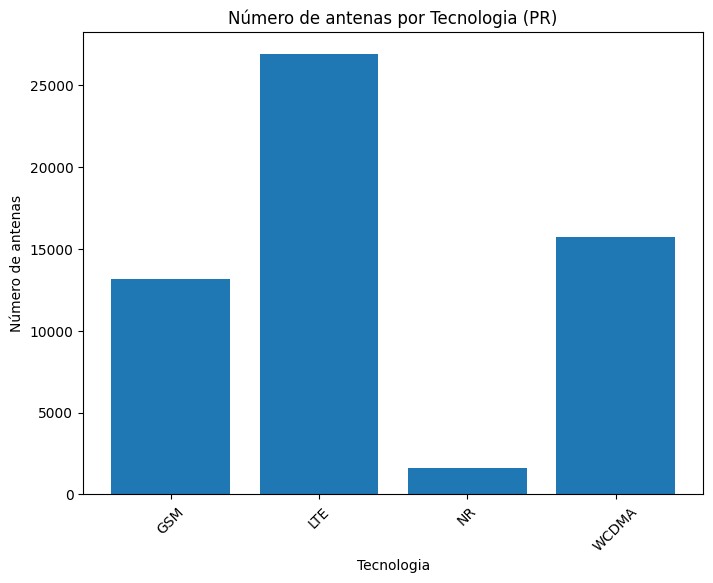

In [ ]:
def gera_grafico_antenas_por_tecnologia():
  df = df_erbs_uf.groupby(['tecnologia']).agg({'estacao': 'count'}).reset_index()
  tecnologia = df['tecnologia'].to_list()
  numero_antenas = df['estacao'].to_list()

  plt.figure(figsize=(8, 6))

  plt.bar(tecnologia, numero_antenas)
  plt.title('Número de antenas por Tecnologia ('+uf.upper()+')')
  plt.xlabel('Tecnologia')
  plt.ylabel('Número de antenas')

  plt.xticks(rotation = 45) 
  plt.show()

gera_grafico_antenas_por_tecnologia()

#### Número de antenas por tecnologia de cada operadora no Estado

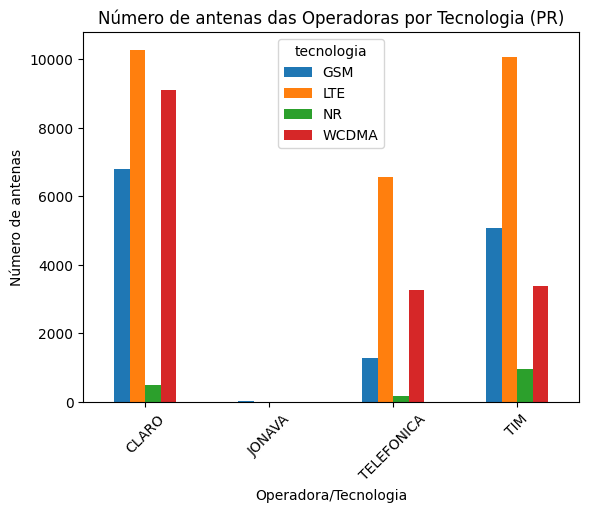

In [ ]:
def gera_grafico_antenas_por_tecnologia_agrupado_por_operadora():
  df = df_erbs_uf
  df['operadora'] = [ o.split()[0] for o in df['operadora']]
  df = df_erbs_uf.groupby(['operadora', 'tecnologia']).agg({'estacao': 'count'}).reset_index()

  operadoras = [ o.split()[0] for o in df['operadora'].to_list() ]
  df = df.pivot(index='operadora', columns='tecnologia', values='estacao')
  df.fillna(0)

  df.plot(kind='bar')

  plt.title('Número de antenas das Operadoras por Tecnologia ('+uf.upper()+')')
  plt.xlabel('Operadora/Tecnologia')
  plt.ylabel('Número de antenas')
  plt.xticks(rotation = 45)  
  plt.show()
  
gera_grafico_antenas_por_tecnologia_agrupado_por_operadora()

####Localização das ERB's

<Figure size 1000x600 with 0 Axes>

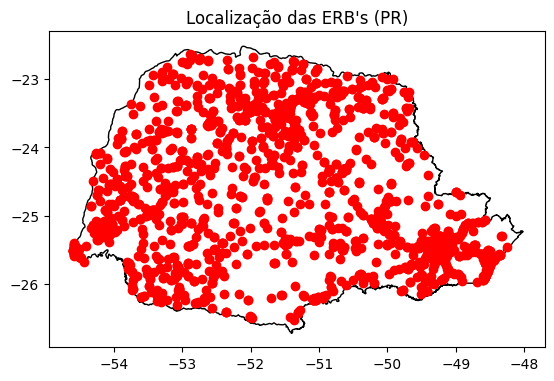

In [ ]:
limite_estado = geobr.read_state(code_state=uf.upper())
plt.figure(figsize=(10, 6))

ax=limite_estado.plot(color='white', edgecolor='black')

plt.title('Localização das ERB\'s ('+uf.upper()+')')

erbs = df_erbs_uf[['estacao', 'latitude', 'longitude']].drop_duplicates()
gdf =gpd.GeoDataFrame(erbs, geometry=gpd.points_from_xy(erbs.longitude, erbs.latitude))
filtro = gdf.within(limite_estado.loc[0, 'geometry'])
gdf = gdf.loc[filtro]
gdf.plot(ax=ax, color='red')
plt.show()
